In [1]:
import pandas as pd
from pathlib import Path
from audio import AudioFeature
from model import Model
from sklearn.ensemble import RandomForestClassifier
import os
import pickle
import numpy as np

In [2]:
def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        # Load audio
        dataset.append([file_path ,label])

    return dataset

In [3]:
trainset_speechcommands_hungry = load_audio_files('./cleandata/hungry', 'hungry')
trainset_speechcommands_burping = load_audio_files('./cleandata/burping', 'burping')
trainset_speechcommands_tired = load_audio_files('./cleandata/tired', 'tired')
trainset_speechcommands_belly_pain = load_audio_files('./cleandata/belly_pain', 'belly_pain')
trainset_speechcommands_discomfort = load_audio_files('./cleandata/discomfort', 'discomfort')
print(f'Length of hungry dataset: {len(trainset_speechcommands_hungry)}')
print(f'Length of burping dataset: {len(trainset_speechcommands_burping)}')
print(f'Length of tired dataset: {len(trainset_speechcommands_tired)}')
print(f'Length of belly_pain dataset: {len(trainset_speechcommands_belly_pain)}')
print(f'Length of discomfort dataset: {len(trainset_speechcommands_discomfort)}')

Length of hungry dataset: 382
Length of burping dataset: 8
Length of tired dataset: 24
Length of belly_pain dataset: 16
Length of discomfort dataset: 27


In [4]:
trainset = (trainset_speechcommands_burping +
            trainset_speechcommands_tired + 
            trainset_speechcommands_belly_pain +
            trainset_speechcommands_discomfort)
print(f'Length of dataset: {len(trainset)}')

Length of dataset: 75


In [5]:
trainset[0]

['cleandata\\burping\\burping (1).wav', 'burping']

In [6]:
audio = AudioFeature('cleandata\\hungry\\hungry (1).wav', 'hungry')

In [19]:
from sklearn import svm
audio_features = []
for row in trainset:
    path, label = row
    audio = AudioFeature(path,label)
    audio.extract_features("mfcc", "spectral")
    audio_features.append(audio)
feature_matrix = np.vstack([audio.features for audio in audio_features])
labels = np.array([audio.label for audio in audio_features])
model_cfg = dict(
    model=svm.SVC,
)
model = Model(feature_matrix, labels, model_cfg)


c:\Users\Admin\Documents\GitHub\infant-classification\audio.py:26: FutureWarning: Pass y=[ 1.4802503e-06  8.1664245e-07 -8.3492654e-07 ...  6.7964599e-02
  2.6345957e-02  7.1490980e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(self.y, sr=self.sr, n_mfcc=n_mfcc)
c:\Users\Admin\Documents\GitHub\infant-classification\audio.py:26: FutureWarning: Pass y=[ 0.00049432  0.00047932  0.00032973 ... -0.00146044 -0.0001469
  0.00033771] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(self.y, sr=self.sr, n_mfcc=n_mfcc)
c:\Users\Admin\Documents\GitHub\infant-classification\audio.py:26: FutureWarning: Pass y=[2.8869018e-04 5.7451212e-04 8.6277223e-04 ... 2.3475604e-04 1.7714064e-04
 9.0743495e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(self.y, sr=self.

In [20]:
model

In [21]:
fold_acc = model.train_kfold()

TypeError: BaseLibSVM.fit() missing 1 required positional argument: 'y'

In [16]:
type(fold_acc)

list

In [17]:
fold_acc

[0.391304347826087]

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:140: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:140: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)


ValueError: zero-size array to reduction operation maximum which has no identity

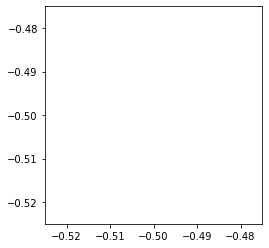

In [18]:
model.matrix()